# Evaluating the karabo detection source
In this notebook, we will evaluate how well the detection source of karabo works (check the meeting of the 13.10.22 on gitlab for more infos: here: https://gitlab.unige.ch/Patrick.Arlt/master-thesis/-/issues/12


In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import numpy as np
import math
import matplotlib.pyplot as plt

import myUtils

import bdsf
from astropy.utils.data import get_pkg_data_filename
from astropy.io import fits
from astropy.table import Table
from astropy.coordinates import SkyCoord
import astropy.units as u

from tqdm import tqdm
import argparse


# Getting the right fits according to the keys given

In [7]:
data_path = '/Users/patoch/Desktop/Patoch/Uni/2nd-Year/MasterThesis/master-thesis/Dataset.nosync'
keys = np.load(os.path.join(data_path, "Sources_detection/sky_keys.npy"))
indices_validation = np.load(os.path.join(data_path, "Sources_detection/seed_0/validation_idx.npy"))
indices_test = np.load(os.path.join(data_path, "Sources_detection/seed_0/test_idx.npy"))

print("Numbber of keys: ", len(keys))
print("Lenght validation set: ", len(indices_validation))
print("Lenght test set: ", len(indices_test))

Numbber of keys:  9164
Lenght validation set:  917
Lenght test set:  916


In [8]:
# List of images paths regarding the train, validation and test set
validation_images_path = [os.path.join(data_path, 'clean_gaussian', "clean_gaussians_" + keys[ind] + ".fits") for ind in indices_validation]
test_images_path = [os.path.join(data_path, 'clean_gaussian', "clean_gaussians_" + keys[ind] + ".fits") for ind in indices_test]

print("Lenght validation set: ", len(validation_images_path))
print("Lenght test set: ", len(test_images_path))

Lenght validation set:  917
Lenght test set:  916


In [9]:
validation_RealDetection = myUtils.loadAllCatFile("/Users/patoch/Desktop/Patoch/Uni/2nd-Year/MasterThesis/master-thesis/Dataset.nosync/Sources_detection/cat", "gaussians_", indices_validation, keys)
test_RealDetection = myUtils.loadAllCatFile("/Users/patoch/Desktop/Patoch/Uni/2nd-Year/MasterThesis/master-thesis/Dataset.nosync/Sources_detection/cat", "gaussians_", indices_test, keys)
print("Lenght train set: ", len(train_RealDetection))
print("Lenght validation set: ", len(validation_RealDetection))
print("Lenght test set: ", len(test_RealDetection))

# compute the pixels index of ground truth positions
validation_RealDetection_px = [myUtils.RaDec2pixels(validation_RealDetection[ind], fits.getheader(validation_images_path[ind])) for ind in tqdm(range(len(validation_RealDetection)))]
test_RealDetection_px = [myUtils.RaDec2pixels(test_RealDetection[ind], fits.getheader(test_images_path[ind])) for ind in tqdm(range(len(test_RealDetection)))]

print()
print(np.array(test_RealDetection_px[0]).shape)
print(np.array(test_RealDetection_px[1]).shape)
print(np.array(test_RealDetection_px[2]).shape)

Lenght train set:  7331
Lenght validation set:  917
Lenght test set:  916


100%|██████████| 916/916 [00:03<00:00, 294.22it/s]


(2, 2)
(2, 3)
(2, 5)


100%|██████████| 916/916 [00:03<00:00, 288.46it/s]


shape validation input:  (917, 512, 512)
shape test input:  (916, 512, 512)


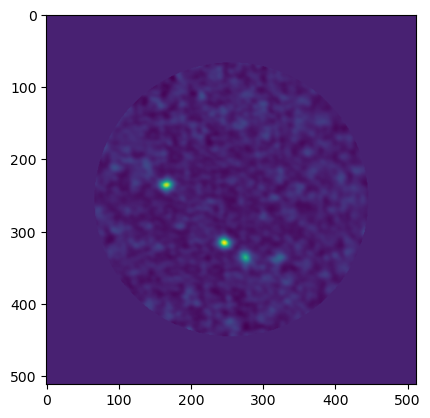

In [5]:
# open fits files from validation_images_path and store them into a tensor validation_input
validation_input = [fits.getdata(validation_images_path[ind])[0,0] for ind in tqdm(range(len(validation_images_path)))]
validation_input = np.nan_to_num(np.array(validation_input), nan=0)

# open fits files from test_images_path and store them into a tensor test_input
test_input = [fits.getdata(test_images_path[ind])[0,0] for ind in tqdm(range(len(test_images_path)))]
test_input = np.nan_to_num(np.array(test_input), nan=0)

print("shape validation input: ", validation_input.shape)
print("shape test input: ", test_input.shape)
plt.figure()
plt.imshow(validation_input[0])
plt.show()

### Loading the real source coordinates

In [10]:
listRealDetection_test = myUtils.loadAllCatFile("/Users/patoch/Desktop/Patoch/Uni/2nd-Year/MasterThesis/master-thesis/Dataset.nosync/Sources_detection/cat", "gaussians_", indices_test, keys)
listRealDetection_validation = myUtils.loadAllCatFile("/Users/patoch/Desktop/Patoch/Uni/2nd-Year/MasterThesis/master-thesis/Dataset.nosync/Sources_detection/cat", "gaussians_", indices_validation, keys)
print(len(listRealDetection_test))
print(len(listRealDetection_validation))

916
917


In [186]:
parser = argparse.ArgumentParser(description='...')
parser.add_argument("--thresh", default=None) 
parser.add_argument("--thresh_pix", default=7, type=int)
parser.add_argument("--rms_map", default=False, type=bool)
parser.add_argument("--rms_value", default=1, type=int)
parser.add_argument("--thresh_isl", default=10, type=int)
args, unknown = parser.parse_known_args()


In [187]:
def applyPyBDSF(input_image, res_dir, args, ind=0, is_debug=False):
    if not args.rms_map:
        img = bdsf.process_image(input=input_image,
                                clobber=True, # Overwrite existing file?
                                output_opts=False,
                                quiet=True,
                                advanced_opts=True,
                                rms_map=False,
                                rms_value=args.rms_value,
                                )
    else:
        img = bdsf.process_image(input=input_image,
                                clobber=True,
                                output_opts=True,
                                quiet=True,
                                thresh=args.thresh,  # default = None
                                thresh_pix=args.thresh_pix,  # default = 5,
                                thresh_isl=args.thresh_isl,  # default = 3, ignored if  thresh="fdr"
                                mean_map = 'zero'
                                )  
        
    # Write the source list catalog. File is named automatically.
    img.write_catalog(outfile=os.path.join(res_dir, "detectedSources_"+str(ind)+".cat"), format='ascii', catalog_type='srl', clobber=True)
    # img.show_fit()
    # Write the residual image. File is named automatically.

    if is_debug:
        # Write the model image. Filename is specified explicitly.
        img.export_image(img_type='island_mask', outfile=os.path.join(res_dir, "island_mask.....fits"), clobber=True)

# t = Table.read(os.path.join(res_dir, "pybdsf.....cat")), format='ascii')




In [188]:
%%capture
for ind in range(len(validation_images_path)):
    image_path = validation_images_path[ind]
    applyPyBDSF(image_path, '/Users/patoch/Desktop/Patoch/Uni/2nd-Year/MasterThesis/master-thesis/pyBdsfTests/Results/', args=args, ind=ind)

stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin is

In [189]:
listDetectedSources_radec = []
for ind in range(len(validation_images_path)):
    sourcesCoord = []
    table = Table.read('/Users/patoch/Desktop/Patoch/Uni/2nd-Year/MasterThesis/master-thesis/PyBdsfTests/Results/detectedSources_' + str(ind) + ".cat", format='ascii')

    for row in range(len(table)):
        sourcesCoord.append([table[row]['col3'].astype(float), table[row]['col5'].astype(float)])

    listDetectedSources_radec.append(np.array(sourcesCoord))

In [190]:
print(len(listRealDetection_validation))
print(len(listDetectedSources_radec))

917
917


In [191]:
listRealDetection_validation_px = [myUtils.RaDec2pixels(listRealDetection_validation[i], fits.open(validation_images_path[i])[0].header) for i in range(len(listRealDetection_validation))]
print(len(listRealDetection_validation_px))

listDetectedSources_px = [myUtils.RaDec2pixels(listDetectedSources_radec[i], fits.open(validation_images_path[i])[0].header) for i in range(len(listDetectedSources_radec))]
print(len(listDetectedSources_px))

917
917


# Do the comparaison

In [192]:
# Compute the TP, FP and FN for the whole test set
resAllComparison = myUtils.compareRealAndDetectedSources_pixels(listDetectedSources_px, listRealDetection_validation_px)
print("Result (TP, FP, FN): ", resAllComparison)

Result (TP, FP, FN):  [2668 4716  102]


# Compute purity and Completenss


In [193]:
purityAll = resAllComparison[0] / (resAllComparison[0] + resAllComparison[1])
CompletnessAll = resAllComparison[0] / (resAllComparison[0] + resAllComparison[2])
print("Purity: ", purityAll)
print("Completness: ", CompletnessAll)

Purity:  0.36132177681473454
Completness:  0.9631768953068592


# Do the same on the Clean Noisy dataset:



In [194]:
validation_noisy_images_path = []   # list containing all the fits file path for the test 

for ind in indices_validation:
    key = keys[ind]

    data = os.path.join(data_path, 'clean_noisy', "clean_noisy_gaussians_" + key + ".fits")
    validation_noisy_images_path.append(data)

In [195]:
%%capture
for ind in tqdm(range(len(validation_noisy_images_path))):
    image_path = validation_noisy_images_path[ind]
    applyPyBDSF(image_path, '/Users/patoch/Desktop/Patoch/Uni/2nd-Year/MasterThesis/master-thesis/pyBdsfTests/Results_noisy/', args=args, ind=ind)

stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin isn't a terminal
stty: stdin is

In [196]:
listDetectedSources_noisy_radec = []
for ind in range(len(validation_images_path)):
    sourcesCoord = []
    try:
        table = Table.read('/Users/patoch/Desktop/Patoch/Uni/2nd-Year/MasterThesis/master-thesis/PyBdsfTests/Results_noisy/detectedSources_' + str(ind) + ".cat", format='ascii')
        for row in range(len(table)):
            sourcesCoord.append([table[row]['col3'].astype(float), table[row]['col5'].astype(float)])
    except:
        # sourcesCoord.append([])
        print("empty")
    
    print(sourcesCoord)

    listDetectedSources_noisy_radec.append(np.array(sourcesCoord))

print(len(listRealDetection_validation))
print(len(listDetectedSources_noisy_radec))

[[150.62148281808732, 2.98748663826891]]
[[150.69285327468472, 1.66270951266277]]
empty
[]
empty
[]
[[149.12861734024614, 2.2583787564111]]
[[148.44972033689774, 3.29498072027359]]
empty
[]
empty
[]
[[151.02805014295808, 3.89237129505507]]
[[151.50450758545313, 2.43302221711597], [151.504044311068, 2.43437132368938]]
[[148.7390736036342, 3.75521952476908]]
empty
[]
empty
[]
[[150.35260136063954, 0.78045234852494]]
empty
[]
empty
[]
empty
[]
empty
[]
[[148.86315209031605, 4.04209402031576]]
[[151.66312047223397, 4.0698232850612]]
empty
[]
[[148.20250984477843, 2.47302933552844]]
empty
[]
[[148.79575347492525, 0.53987375409495]]
empty
[]
[[149.99462053949557, 1.67238473463937]]
empty
[]
empty
[]
[[149.74368516285696, 3.59470452620013], [149.74288113954728, 3.59694556155575]]
[[151.4103175236116, 2.8107267085103]]
[[148.72172817033294, 3.29955493821171]]
[[149.42453985465082, 2.44037648811958], [149.42397275195006, 2.4409836970943], [149.4218219495868, 2.44067387056921]]
empty
[]
empty
[]

In [197]:
listDetectedSources_noisy_px = [myUtils.RaDec2pixels(listDetectedSources_noisy_radec[i], fits.open(validation_images_path[i])[0].header) for i in range(len(listDetectedSources_noisy_radec))]
print(len(listDetectedSources_noisy_px))
print(len(listRealDetection_validation_px))


917
917


In [198]:
# Compute the TP, FP and FN for the whole test set
resAllComparison = myUtils.compareRealAndDetectedSources_pixels(listDetectedSources_noisy_px, listRealDetection_validation_px)
print("Result (TP, FP, FN): ", resAllComparison)

purityAll = resAllComparison[0] / (resAllComparison[0] + resAllComparison[1])
CompletnessAll = resAllComparison[0] / (resAllComparison[0] + resAllComparison[2])
print("Purity: ", purityAll)
print("Completness: ", CompletnessAll)

Result (TP, FP, FN):  [ 492    8 2278]
Purity:  0.984
Completness:  0.1776173285198556
